In [13]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Step 1: Data aquisition
1.1 read and clean city/population data from UN  
1.2 get coordinates for all cities using `geopy.geocoder`  
1.3 bin population size  
1.4 for each city get all venues within 5km radius of city center using `foursquare` API

### 1.1 read and clean city/population data from UN

In [14]:
# possibly need to clean up the table a bit before. add countries to cities and remove footnotes

# read and format population table
population = pd.read_excel('table08.xlsx', skiprows=4)
population = population[['Unnamed: 0', 'Both sexes\nLes deux sexes']]
population.rename(columns={"Unnamed: 0": "City", "Both sexes\nLes deux sexes": "Population Size"}, inplace = True)
# only keep cities with population data
print(population.shape)
population.dropna(inplace = True)
population = population[population['Population Size'] != '...']
print(population.shape)
population.head()

(4048, 2)
(2771, 2)


,City,Population Size
3,Adrar,200834
4,Ain Defla,450280
5,Ain Temouchent,299341
6,ALGIERS (EL DJAZAIR),2712944
7,Annaba,442230


### 1.2 get coordinates for all cities using `geopy.geocoder`

In [21]:
# add longitude and latitude to table
# initialize column, only necessary because it is using the column before it's first assignment
population['Country'] = ''

In [33]:
for i in population.index:
    city = population.at[i,'City']
    country = population.at[i,'Country']
    if country == '':
        #print(city)
        geolocator = Nominatim(user_agent="foursquare_agent")
        location = geolocator.geocode(city)
        if not location == None:
            # get longitude and latitude 
            latitude = location.latitude
            longitude = location.longitude
            coordinates = '%s,%s' %(latitude, longitude)
            # get country of city, might be interesting for later
            location_reverse = geolocator.reverse(coordinates, language='en')
            loc = location_reverse.raw
            if 'country' in loc['address'].keys():
                country = loc['address']['country']
            else:
                country = 'None'
        else:
            latitude = np.nan
            longitude = np.nan
            country = np.nan
        population.at[i, 'Country'] = country
        population.at[i, 'Latitude'] = latitude
        population.at[i, 'Longitude'] = longitude

print(population.shape)
population.head()

(2555, 6)


,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,26.488816,-1.358244,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,35.211183,4.183990,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


In [34]:
population.tail()

,City,Population Size,Country,Latitude,Longitude,population_bin
2550,ADAMSTOWN,49.0,Pitcairn,-25.066667,-130.100205,1
2551,APIA,37391.0,Samoa,-13.834369,-171.769279,1
2552,HONIARA,64609.0,Solomon Islands,-9.431077,159.955255,1
2553,FUNAFUTI,6152.0,Tuvalu,-8.534995,179.118650,1
2554,PORT VILA,44039.0,Vanuatu,-17.741497,168.315016,1


### 1.3 bin population size  

In [35]:
# drop cities without location
population.dropna(inplace=True)
population.head()

def bin_pop_size(x):
    if x < 500000:
        bin_pop = 1
    elif x >= 500000 and x < 1000000:
        bin_pop = 2
    elif x >= 1000000 and x < 5000000:
        bin_pop = 3
    elif x >= 5000000 and x < 10000000:
        bin_pop = 4
    elif x >= 10000000 and x < 20000000:
        bin_pop = 5
    elif x >= 20000000:
        bin_pop = 6
    return bin_pop

# create a column indicating the bin based on population size
population['population_bin'] = population['Population Size'].apply(lambda x: bin_pop_size(x))

# safe table
population.to_excel('population_table.xlsx')

# look at table which we will use for the rest
print(population.shape)
population.head()


(2555, 6)


,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,26.488816,-1.358244,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,35.211183,4.183990,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


Okay, now that we have the cities location, their population size and their country  we can as foursquares to get all venues in a 5km radius around the city center

In [36]:
population = pd.read_excel('population_table.xlsx')
population.drop(['Unnamed: 0'], axis = 1, inplace = True)
population.head()

,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,26.488816,-1.358244,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,35.211183,4.183990,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


In [37]:
# setting up the credentials for Foursqaure
CLIENT_ID = 'RH1MSDYU04B3JZQ31VMVTEQVZONTRLRKVP4DTM4A2XVQSZW3' # your Foursquare ID
CLIENT_SECRET = '1GIGN1TNCP5E0KUQCG10RHZWKTTH4EGAPGV4K2EHKSATD3TL' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 5000
radius = 5000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RH1MSDYU04B3JZQ31VMVTEQVZONTRLRKVP4DTM4A2XVQSZW3
CLIENT_SECRET:1GIGN1TNCP5E0KUQCG10RHZWKTTH4EGAPGV4K2EHKSATD3TL


### 1.4 for each city get all venues within 5km radius of city center using `foursquare` API

In [31]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        
        if 'groups' in results['response'].keys() and len(results["response"]['groups'][0]['items']) > 0:
            results = results["response"]['groups'][0]['items']
            
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        
        
        else:   
            venues_list.append([(
                name, 
                lat, 
                lng, 
                np.nan, 
                np.nan, 
                np.nan,  
                np.nan)])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                      'City Latitude', 
                      'City Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
    
    return(nearby_venues)

In [32]:
city_venues = getNearbyVenues(names=population['City'],
                                   latitudes=population['Latitude'],
                                   longitudes=population['Longitude']
                                  )

city_venues.head()


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adrar,26.488816,-1.358244,NaN,NaN,NaN,NaN
1,Ain Defla,36.158684,2.084282,NaN,NaN,NaN,NaN
2,Ain Temouchent,35.266657,-1.149928,NaN,NaN,NaN,NaN
3,ALGIERS (EL DJAZAIR),35.211183,4.183990,Hotel Kerdada Bou Saada,35.211229,4.184034,Hotel
4,ALGIERS (EL DJAZAIR),35.211183,4.183990,Pizzeria Printania,35.211276,4.182763,Pizza Place


In [38]:
city_venues.columns = ['City', 
                      'City Latitude', 
                      'City Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']

In [39]:
# safe table
#city_venues.to_excel('city_venues.xlsx')

# look at table which we will use for the rest
print(city_venues.shape)
city_venues.head()

(61149, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adrar,26.488816,-1.358244,NaN,NaN,NaN,NaN
1,Ain Defla,36.158684,2.084282,NaN,NaN,NaN,NaN
2,Ain Temouchent,35.266657,-1.149928,NaN,NaN,NaN,NaN
3,ALGIERS (EL DJAZAIR),35.211183,4.183990,Hotel Kerdada Bou Saada,35.211229,4.184034,Hotel
4,ALGIERS (EL DJAZAIR),35.211183,4.183990,Pizzeria Printania,35.211276,4.182763,Pizza Place


In [136]:
# read in table
city_venues = pd.read_excel('city_venues.xlsx', index_col= 0)
city_venues.dropna(inplace = True)
city_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,ALGIERS (EL DJAZAIR),35.211183,4.183990,Pizzeria Printania,35.211276,4.182763,Pizza Place
4,ALGIERS (EL DJAZAIR),35.211183,4.183990,Hotel Kerdada Bou Saada,35.211229,4.184034,Hotel
5,ALGIERS (EL DJAZAIR),35.211183,4.183990,Marché de Bou-Saada,35.212458,4.180231,Market
6,Annaba,36.898216,7.754927,"Place de la révolution ""EL Cour """,36.897399,7.760449,Historic Site
7,Annaba,36.898216,7.754927,bazaar,36.899019,7.757154,Market


In [137]:
population.head()

,City,Population Size,Country,Latitude,Longitude,population_bin
0,Adrar,200834.0,Algeria,26.488816,-1.358244,1
1,Ain Defla,450280.0,Algeria,36.158684,2.084282,1
2,Ain Temouchent,299341.0,Algeria,35.266657,-1.149928,1
3,ALGIERS (EL DJAZAIR),2712944.0,Algeria,35.211183,4.183990,3
4,Annaba,442230.0,Algeria,36.898216,7.754927,1


## Step 2: Data wrangeling
2.1 redefine groups  
2.2 get one-hot encoding for Venue Category and/or Grouped Venue Category  
2.3 summarize by ciy either mean or sum  
2.4 merge with population data  

### 2.1 redefine groups (not doing that for now)

### 2.2 get one-hot encoding for Venue Category (and or Grouped Venue Category)

In [138]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

city_onehot.drop(['City'], axis = 1, inplace = True)
# add neighborhood column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,City,ATM,Acai House,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,Auvergne Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Baiano Restaurant,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campanian Restaurant,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Central Brazilian Restaurant,Champagne Bar,Cheese Shop,Chettinad Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Library,College Rec Center,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Goiano Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gukbap Restaurant,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Servic

### 2.3 summarize by ciy either sum (or mean)  


In [139]:
city_grouped = city_onehot.groupby('City').sum().reset_index()
city_grouped.head()

,City,ATM,Acai House,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,Auvergne Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Baiano Restaurant,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campanian Restaurant,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Central Brazilian Restaurant,Champagne Bar,Cheese Shop,Chettinad Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Library,College Rec Center,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Goiano Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gukbap Restaurant,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Servic

### 2.4 merge with population data  

In [140]:
# add population and location data to data, and save table
population_venue_data = population.merge(city_grouped, on = 'City')
population_venue_data.to_excel('population_venue_data.xlsx')
population_venue_data.head()

,City,Population Size,Country,Latitude,Longitude,population_bin,ATM,Acai House,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Apres Ski Bar,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Ash and Haleem Place,Asian Restaurant,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,Auvergne Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Baggage Locker,Baiano Restaurant,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Batik Shop,Bavarian Restaurant,Bay,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belarusian Restaurant,Belgian Restaurant,Betting Shop,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blini House,Board Shop,Boarding House,Boat or Ferry,Bookstore,Bossam/Jokbal Restaurant,Botanical Garden,Bougatsa Shop,Boutique,Bowling Alley,Boxing Gym,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Bulgarian Restaurant,Burger Joint,Burgundian Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campanian Restaurant,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Capitol Building,Caribbean Restaurant,Carpet Store,Casino,Castle,Caucasian Restaurant,Cave,Central Brazilian Restaurant,Champagne Bar,Cheese Shop,Chettinad Restaurant,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Cigkofte Place,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Library,College Rec Center,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cruise,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Dizi Place,Doctor's Office,Dog Run,Donburi Restaurant,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Dutch Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Emilia Restaurant,Empada House,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Goiano Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gukbap Restaurant,Gun Shop,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina

## Step 3: Visualize data
3.1 PCA  
3.2 TSNE  
3.3 barplot or boxplot for group Venues  
3.4 plot number of venues vs. number of categories (showing diversity)  

### 3.1 PCA

(1886, 648)
Explained variation per principal component: [0.02557464 0.0116722 ]


<Figure size 842.4x595.44 with 0 Axes>

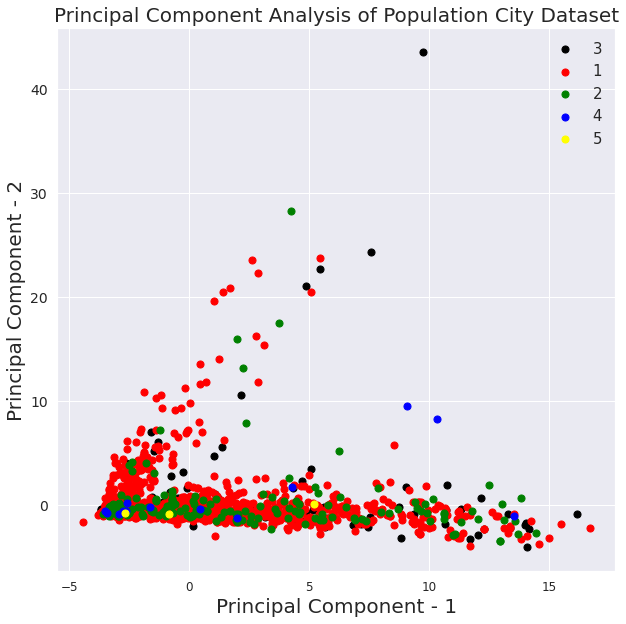

In [153]:
# look at data with PCA and TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# remove city and country for the PCA
X = population_venue_data.drop(population_venue_data.iloc[:, 0:6], inplace=False, axis=1)
print(X.shape)

x_pca = StandardScaler().fit_transform(X) # normalizing the features
pca_cities = PCA(n_components=2)
principalComponents_cities = pca_cities.fit_transform(x_pca)
PC_cities_Df = pd.DataFrame(data = principalComponents_cities
             , columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca_cities.explained_variance_ratio_))

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Population City Dataset",fontsize=20)
targets = population_venue_data['population_bin'].unique()
colors = ['black','red', 'green', 'blue', 'yellow']
for target, color in zip(targets,colors):
    indicesToKeep = population_venue_data['population_bin'] == target
    plt.scatter(PC_cities_Df.loc[indicesToKeep, 'principal component 1']
               , PC_cities_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

### 3.2 TSNE

<Figure size 842.4x595.44 with 0 Axes>

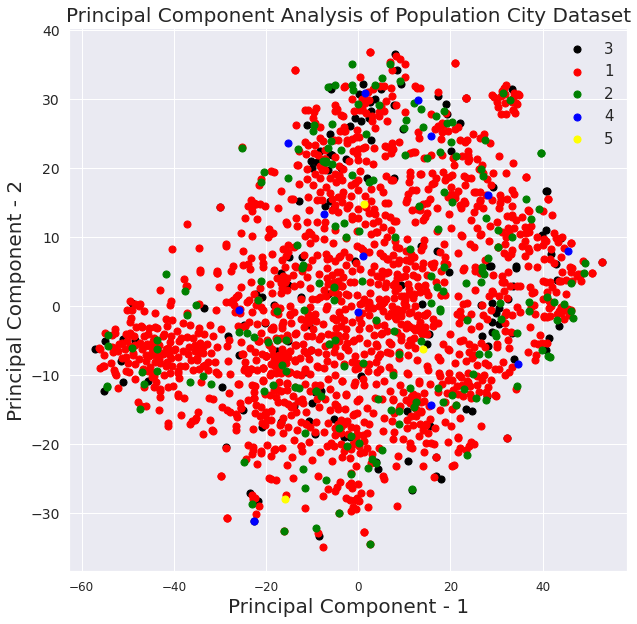

In [155]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

X = population_venue_data.drop(population_venue_data.iloc[:, 0:6], inplace=False, axis=1)

tsne = TSNE(perplexity = 30)
X_embedded = tsne.fit_transform(X)

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Population City Dataset",fontsize=20)

targets = population_venue_data['population_bin'].unique()
colors = ['black','red', 'green', 'blue', 'yellow']

for target, color in zip(targets,colors):
    indicesToKeep = population_venue_data['population_bin'] == target
    plt.scatter(X_embedded[indicesToKeep,0]
               , X_embedded[indicesToKeep,1], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

#sns.scatterplot(, X_embedded[:,1])

## Step 4: Write function to find similar city
4.1 input: population/venue data, favorite city, number of similar cities, choice of algorithm, select or deselect categories  
4.2 remove or select specified categories  
4.3 use hierachical clustering to find x similar cities  
4.4 return similar cities  
4.5 make a heatmap showing similar cities and features (!=0)  

## Step 5: Apply functions
5.1 show the result for 5 examples  
5.2 pretend to select a city  
5.3 use `foursquare` to get more information on an example city  

## Possible discussion points and future directions. 
- select more cities and create an average of input cities
- select more cities and use K-means clustering with selected cities as input
  - show top venues for each cluster
  - build recommender engine for selecting multiple cities